# Correspondence Analysis with Implementation

- Bowen Li
- 2016/10/06

## Outline

1. What is Correspondence Analysis?
2. Why Correspondence Analysis?
3. Methodology Summary
4. Visualization Maps
5. Implementation from Scratch

## 1. What is Correspondence Analysis?
- **Aggregate data based:** more useful and convenient, compared with raw data-based.
- **Dimension reduction:** represent associations in a table of nonnegative **counts.**
- **Data visualization for association**: the positions of the points reflect associations.

### Numerous Applications

- Segments vs. Genders
- Segments vs. 24 hours
- Segments vs. 7 weekdays
- Segments vs. Locations
- Segments vs. App detection
- Segments vs. {only-impressions, with-clicks and further-with-actions}
- Campaigns vs. {only-impressions, with-clicks and further-with-actions}
- Other groups vs. characteristics, etc...

### Correspondence analysis of archaeological data: sites vs. types
<img src="./images/contingency_table.png" alt="Drawing" style="width: 450px;"/>

Common data visualizations:

<img src="./images/site_type_profile.png" alt="Drawing" style="width: 700px;"/>

However, common data visualizations of type by site (left) and site by type (right) **cannot quantify associations.**

**Correspondence analysis vidualization:**

<img src="./images/ca_demo.png" alt="Drawing" style="width: 550px;"/>

- **Sites association:** 
  * *P1* and *P2* are close together, and thus have similar **type profiles**
  * *P0* ad *P6* are far apart, and thus have different type profiles
- **Types association:**
  * *A*, *B*, *C* and *D* have different **site profiles**
- **Site and type association:** (rough, see later)
  * Site *P0* is associated almost exclusively with type *D*
  * Site *P6* is similarly associated with type *C*
  * Sites *P1*, *P2* and *P3* (to lesser degrees) are associated with type *A*
- **Measure of retained information:**
  * **Inertia:** amount of retained information with
    - 1st dimension: $\lambda^2_1 = 0.28 (55\%)$
    - 2nd dimension: $\lambda^2_2 = 0.17 (28\%)$
  * The two dimensions account for $55\% + 28\% = 88\%$ of the total inertia
  * The representations fits the data well

## 2. Why Correspondence Analysis?

Reference: Abdi & Williams (2010).

In [12]:
from __future__ import division
from __future__ import print_function

import numpy as np
import scipy as sp 
import pandas as pd

In [14]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(ggplot2)
library(scales)
library(dplyr)
library(data.table)
library(grid)
library(gridExtra)

library(ca)

**French authors dataset:**
- Goal: Derive a map that reveals the **similarities in punctuation style between authors.**
- Note: Zola, who wrote a *small* novel under a pseudonym of Aloz.

In [15]:
data = {'period': [7836, 53655, 115615, 161926, 38177, 46371, 2699],
        'comma': [13112, 102383, 184541, 340479, 105101, 58367, 5675],
        'others': [6026, 42413, 59226, 62754, 12670, 14299, 1046]}
data = pd.DataFrame(data, columns=['period', 'comma', 'others'],
                    index=['Rousseau', 'Chateaubriand', 'Hugo', \
                           'Zola', 'Proust', 'Giraudoux', 'Aloz'])
data

,period,comma,others
Rousseau,7836,13112,6026
Chateaubriand,53655,102383,42413
Hugo,115615,184541,59226
Zola,161926,340479,62754
Proust,38177,105101,12670
Giraudoux,46371,58367,14299
Aloz,2699,5675,1046


**First (bad) idea: PCA (sometimes)**
- Aloz punctuates the style similarity as Zola, but is farther away from Zola than any authors.
- That is because **PCA is mainly sensitive to the number** of produced punctuation marks. 

<img src="./images/bad_pca.png" alt="Drawing" style="width: 700px;" align="left" />

**Correspondence analysis is successful:**
- From correspondence analysis results, Aloz and Zola are close together!
- It successfully **reveals profile (style) similarity.**

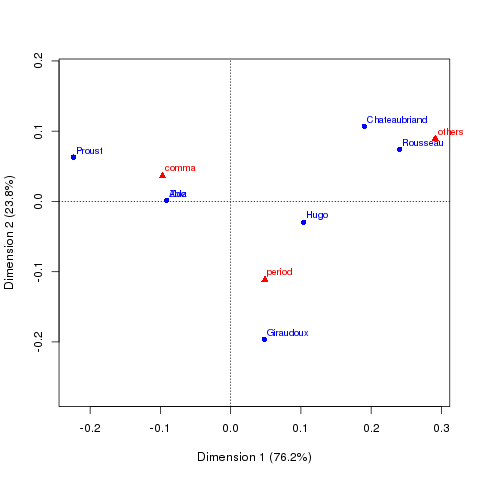

In [28]:
%%R -i data
plot(ca(data))

## 3. Methodology Summary
Correspondence Analysis is based on **generalized singular value decomposition (SVD),** which is similar to **principal component analysis (PCA),** except that the former applies to categorical rather than continuous data; for introduction see [post](https://bowen0701.github.io/2016/10/05/sml-pca-svd).

### Correspondence analysis methodology
- Let the observed data be a **contigency table** of *unscaled* **counts** which is summarized data,

$$
\underset{(I \times J)}X = \{x_{ij}\} =
\begin{bmatrix}
x_{11} & \cdots & x_{1J} \\
\vdots &        & \vdots \\ 
x_{I1} & \cdots & x_{IJ}
\end{bmatrix}
$$

- The rows and columns of $X$ correspond to different **categories (groups)** of different **characteristics.**

Define:
- **Correspondence matrix**: divide $x_{ij}$ by **total count,** $n = \textstyle \sum_{i=1}^I \sum_{j=1}^J x_{ij}$, to obtain

$$
p_{ij} = \frac{1}{n} x_{ij}, or 
\underset{I \times J}P = \frac{1}{n} X
$$

- **Row and column profiles:**

$$
r_i = \sum_{j=1}^J p_{ij} = \frac{1}{n} \sum_{j=1}^J x_{ij}, or \underset{I \times 1} r = P \mathbf{1}_J
$$
$$
c_j = \sum_{i=1}^I p_{ij} = \frac{1}{n} \sum_{i=1}^I x_{ij}, or \underset{J \times 1} c = P^T \mathbf{1}_I
$$

- Diagonal matrices with elements of $r$ and $c$:

$$
D_r = diag(r_1,...,r_I)
$$
$$
D_c = diag(c_1,...,c_J)
$$

**Correspondence analysis:**
- It can be formulated as the **reduced rank-K "weighted" least squares approximation** to select $\widehat{P} = \{p_{ij}\}$ which **minimizes**

$$
\sum_{i=1}^I \sum_{j=1}^J \frac{\left( p_{ij} - \widehat{p}_{ij} \right)^2}{r_i c_j}
= tr \left[ \left( D_r^{-1/2} (P - \widehat{P}) D_c^{-1/2} \right) \left( D_r^{-1/2} (P - \widehat{P}) D_c^{-1/2} \right)^T \right]
$$

- **Result from Johnson & Wichern (2002), p. 72:** The term $r c^T$ is common to the approximation $\widehat{P}$ whatever the correspondence matrix $P$.
- Thus, it is equivalent to minimize

$$
tr \left[ \left( D_r^{-1/2} (P - r c^T - \widehat{P}) D_c^{-1/2} \right) \left( D_r^{-1/2} (P - r c^T - \widehat{P}) D_c^{-1/2} \right)^T \right]
$$

- Similarly with SVD, compute the **SVD of $D_r^{-1/2} (P - r c^T) D_c^{-1/2}$**:

$$
D_r^{-1/2} (P - r c^T) D_c^{-1/2} = U \Sigma V^T
$$

where $U$ and $V$ are *orthogonal* matrices with $U^T U = V^T V = I$, and $\Sigma$ is a rank-K *diagonal* matrix.

- Thus,

$$
P - r c^T = D_r^{1/2} \left( U \Sigma V^T \right) D_c^{1/2}
          = A \Sigma B
$$

where $A = D_r^{1/2} U$ and $B = D_c^{1/2} V$.

- The above decomposition is often called **generalized SVD:**

$$
P - r c^T = A \Sigma B, \mbox{ with } A^T D_r^{-1} A =  B^T D_c^{-1} B = I
$$

- **Row profile matrix:** divide each row by its sum,

$$
R = D_r^{-1} P = 
\begin{bmatrix}
\frac{p_{11}}{r_1} & \frac{p_{12}}{r_1} & \cdots & \frac{p_{1J}}{r_1} \\
\vdots &        & \vdots \\ 
\frac{p_{I1}}{r_I} & \frac{p_{I2}}{r_I} & \cdots & \frac{p_{IJ}}{r_I} \\
\end{bmatrix}
$$

- **Column profile matrix:** divide each column by its sum,

$$
C = P D_c^{-1} = 
\begin{bmatrix}
\frac{p_{11}}{c_1} & \frac{p_{12}}{c_2} & \cdots & \frac{p_{1J}}{c_J} \\
\vdots &        & \vdots \\ 
\frac{p_{I1}}{c_1} & \frac{p_{I2}}{c_2} & \cdots & \frac{p_{IJ}}{c_J} \\
\end{bmatrix}
$$

- **Row deviations from average row profile:**

$$
R - \mathbf{1}_I c^T = D_r^{-1} P - \mathbf{1}_I c^T
         = D_r^{-1} (P - rc^T)
         = D_r^{-1} A \Sigma B^T \\
         = D_r^{-1} \left( D_r^{1/2} U \right) \Sigma B^T
         = D_r^{-1/2} U \Sigma B^T
$$

- **Column deviations from average column profile:** similarly,

$$
(C - r\mathbf{1}_J^T)^T = D_c^{-1} P - r\mathbf{1}_J^T
                        =  D_c^{-1/2} V \Sigma A^T 
$$

- **Principal coordinates of rows:** The coordinates for $(R - \mathbf{1}_I c^T)$ w.r.t. the axes of $b_1,...,b_k$ are given by the columns of

$$
F = D_r^{-1/2} U \Sigma
$$

- **Principal coordinates of columns:** The coordinates for $(C - r\mathbf{1}_J^T)^T$ w.r.t. the axes of $b_1,...,b_k$ are given by the columns of

$$
G = D_c^{-1/2} V \Sigma
$$

- **Standard coordinates of rows:**

$$
\Phi = D_r^{-1/2} U
$$

- **Standard coordinates of columns:**

$$
\Gamma = D_c^{-1/2} V
$$

- Relationship:

$$
F^T D_r F = G^T D_c G = \Sigma^2
$$
$$
\Phi^T D_r \Phi = \Gamma^T D_c \Gamma = I
$$

**Inertia:** total variance of the correspondence matrix $P$, which resembles a chi-square statistic,

$$
Inertia = \sum_{i=1}^I \sum_{j=1}^J \frac{\left( p_{ij} - r_i c_j \right)^2}{r_i c_j} 
        = \sum_{k=1}^K \lambda_k^2
$$


**Evaluation of 2D graphical display:**
- **Inertia associated with dimension $k$, for $k = 1,2$:** $\lambda_k^2$.
- **Proportion of total inertia:** explained total variance; the larger, the better.

$$
\frac{\left(\lambda_1^2 + \lambda_2^2 \right)}{\sum_{k=1}^K \lambda_k^2}
$$

## 4. Visualization Maps

- **(1) Symmetric map:** $(F, G)$, rows and columns in principal coordinates.
- **(2) Asymmetric map with row principal:** $(F, \Gamma)$, rows (of more interest) in principal and columns in standard coordinates.
- **(3) Asymmetric map with column principal:** $(\Phi, G)$, rows in standard and columns (of more interest) in principal corordinates. 

**Symmetric map (1):**
- Since principal coordinates of rows and columns, $(F, G)$, are scaled similarly, **joint display of two separate maps** finds some justification.
- Distances between row points (and between column points) are meaningful.
- However, there is a **danger in interpreting row-to-column distances directly:** not possible to deduce from the closeness of a row and column point the fact that the corresponding row and column necessarily have a high association.

**Asymmetric maps (2) and (3):**
- Notice that the **row and column points in biplot lie in the same space**, with the column points defining the most extreme profiles possible, and for example, row profiles are at weighted averages of the column points, the weights being the profile elements.
- Hence, closeness of a row and column point indicates a high association; we can calculate **row-to-column distances for one column at a time.**

Figures 9.4 in Greenacre (2007):
<img src="./images/symmetric_map.png" alt="Drawing" style="width: 550px;"/>

Figures 9.5 in Greenacre (2007):

<img src="./images/asymmetric_map.png" alt="Drawing" style="width: 550px;"/>

## 5. Implementation from Scratch

I implement Correspondence Analysis from scratch as follows; to download the scripts please refert to my corresponding [GitHub repo](https://github.com/bowen0701/corranal).

In [1]:
# corranal2.py: Python Correspondence Analysis
from __future__ import division
from __future__ import print_function

import numpy as np
import scipy as sp 
import pandas as pd
from numpy.linalg import svd

def _coordinates_df(array_x1, array_x2, rows, cols):
    """Create pandas DataFrame with coordinates in rows and columns.
        
    Args:
      array_x1: numpy array, coordinates in rows.
      array_x2: numpy array, coordinates in columns.
      rows: numpy array, row group name.
      cols: numpy array, column group name.
        
    Returns:
      coord_df: pandas DataFrame with columns {'x_1',..., 'x_K', 'point', 'coord'}:
        x_k, k=1,...,K: K-dimensional coordinates.
        point: row and column points for labeling.
        coord: {'row', 'col'}, indicates row point or column point.
    """
    row_df = pd.DataFrame(
        array_x1, columns=['x' +  str(i) for i in (np.arange(array_x1.shape[1]) + 1)])
    row_df['point'] = rows
    row_df['coord'] = 'row'
    col_df = pd.DataFrame(
        array_x2, columns=['x' +  str(i) for i in (np.arange(array_x2.shape[1]) + 1)])
    col_df['point'] = cols
    col_df['coord'] = 'col'         
    coord_df = pd.concat([row_df, col_df], ignore_index=True)
    return coord_df

def ca(df, option='symmetric'):
    """Correspondence Analysis.
    
    This method performs generalized singular value decomposition (SVD) for
    correspondence matrix and computes principal and standard coordinates for
    rows and columns.
    
    ### Usage
    
    ```
    ca_output = ca(author_data, option='symmetric')
    coord_df = ca_output['coordinates']
    inertia_prop = ca_output['inertia_proportion']
    ```
    
    Args:
      df: pandas DataFrame, with row and column names.
      option: string, in one of the following three:
        'symmetric': symmetric map with 
          - rows and columns in principal coordinates.
        'rowprincipal': asymmetric map with 
          - rows in principal coordinates and 
          - columns in standard coordinates.  
        'colprincipal': asymmetric map with 
          - rows in standard coordinates and 
          - columns in principal coordinates.
    
    Returns:
      d : dict, information dict.
        * d['coordinates']: pandas DataFrame, contains coordinates, row and column points. 
        * d['inertia_proportion']: numpy array, contains proportions of total inertia explained 
            in coordinate dimensions.
    
    Raises:
      TypeError: The input is not a pandas DataFrame
      ValueError: Numpy array contains missing values.
      TypeError: Numpy array contains data types other than numeric.
      ValueError: Option only includes {"symmetric", "rowprincipal", "colprincipal"}.
    """

    if isinstance(df, pd.DataFrame) is not True:
        raise TypeError('The input is not a pandas DataFrame.')  
    rows = np.array(df.index)
    cols = np.array(df.columns)
    np_data = np.array(df.values)      
    if np.isnan(np_data).any():
        raise ValueError('Numpy array contains missing values.')
    if np.issubdtype(np_data.dtype, np.number) is not True:
        raise TypeError('Numpy array contains data types other than numeric.')

    p_corrmat = np_data / np_data.sum()
    r_profile = p_corrmat.sum(axis=1).reshape(p_corrmat.shape[0], 1)
    c_profile = p_corrmat.sum(axis=0).reshape(p_corrmat.shape[1], 1)
    Dr_invsqrt = np.diag(np.power(r_profile, -1/2).T[0])
    Dc_invsqrt = np.diag(np.power(c_profile, -1/2).T[0])
    ker_mat = np.subtract(p_corrmat, np.dot(r_profile, c_profile.T))
    left_mat = Dr_invsqrt
    right_mat = Dc_invsqrt
    weighted_lse = left_mat.dot(ker_mat).dot(right_mat)
    U, sv, Vt = svd(weighted_lse, full_matrices=False)
    V = Vt.T
    SV = np.diag(sv)
    inertia = np.power(sv, 2)
    
    if option == 'symmetric':
        # Symmetric map with pricipal coordinates for rows and columns.
        F = Dr_invsqrt.dot(U).dot(SV)
        G = Dc_invsqrt.dot(V).dot(SV)
        coordinates = _coordinates_df(F, G, rows, cols)
    elif option == 'rowprincipal':
        # Asymmetric map with principal coordinates for rows and standard ones for columns.
        F = Dr_invsqrt.dot(U).dot(SV)
        Gam = Dc_invsqrt.dot(V)
        coordinates = _coordinates_df(F, Gam, rows, cols)
    elif option == 'colprincipal':
        # Asymmetric map with standard coordinates for rows and principal ones for columns.
        Phi = Dr_invsqrt.dot(U)
        G = Dc_invsqrt.dot(V).dot(SV)
        coordinates = _coordinates_df(Phi, G, rows, cols)
    else:
        raise ValueError(
            'Option only includes {"symmetric", "rowprincipal", "colprincipal"}.')
    
    inertia_proportion = (inertia / inertia.sum())

    d = {'coordinates': coordinates, 
         'inertia_proportion': inertia_proportion}
    
    return d

In [1]:
# corranal.py: Python Correspondence Analysis
from __future__ import division
from __future__ import print_function

import numpy as np
import scipy as sp 
import pandas as pd
from numpy.linalg import svd

class CA(object):
    """Correspondence analysis (CA).
    
    Methods:
      fit: Fit correspondence analysis.
      get_coordinates: Get symmetric or asymmetric map coordinates.
      score_inertia: Get score inertia.

    ### Usage

    ```python
    corranal = CA(aggregate_cnt)
    corranal.fit()
    coord_df = corranal.get_coordinates()
    inertia_prop = corranal.score_inertia()
    ```
    """

    def __init__(self, df):
        """Create a new Correspondence Analysis.
        
        Args:
          df: Pandas DataFrame, with row and column names.
          
        Raises:
          TypeError: Input data  is not a pandas DataFrame
          ValueError: Input data  contains missing values.
          TypeError: Input data  contains data types other than numeric.
        """
        if isinstance(df, pd.DataFrame) is not True:
            raise TypeError('Input data is not a Pandas DataFrame.')  
        self._rows = np.array(df.index)
        self._cols = np.array(df.columns)
        self._np_data = np.array(df.values)      
        if np.isnan(self._np_data).any():
            raise ValueError('Input data contains missing values.')
        if np.issubdtype(self._np_data.dtype, np.number) is not True:
            raise TypeError('Input data contains data types other than numeric.')

    def fit(self):
        """Compute Correspondence Analysis.

        Fit method is to
          - perform generalized singular value decomposition (SVD) for 
            correspondence matrix and 
          - compute principal and standard coordinates for rows and columns.

        Returns:
          self: Object.
        """     
        p_corrmat = self._np_data / self._np_data.sum()
        r_profile = p_corrmat.sum(axis=1).reshape(p_corrmat.shape[0], 1)
        c_profile = p_corrmat.sum(axis=0).reshape(p_corrmat.shape[1], 1)
        Dr_invsqrt = np.diag(np.power(r_profile, -1/2).T[0])
        Dc_invsqrt = np.diag(np.power(c_profile, -1/2).T[0])
        ker_mat = np.subtract(p_corrmat, np.dot(r_profile, c_profile.T))
        left_mat = Dr_invsqrt
        right_mat = Dc_invsqrt
        weighted_lse = left_mat.dot(ker_mat).dot(right_mat)
        U, sv, Vt = svd(weighted_lse, full_matrices=False)
        self._Dr_invsqrt = Dr_invsqrt
        self._Dc_invsqrt = Dc_invsqrt
        self._U = U
        self._V = Vt.T
        self._SV = np.diag(sv)
        self._inertia = np.power(sv, 2)
        # Pricipal coordinates for rows and columns.
        self._F = self._Dr_invsqrt.dot(self._U).dot(self._SV)
        self._G = self._Dc_invsqrt.dot(self._V).dot(self._SV)
        # Standard coordinates for rows and columns.
        self._Phi = self._Dr_invsqrt.dot(self._U)
        self._Gam = self._Dc_invsqrt.dot(self._V)
        return self
    
    def _coordinates_df(self, array_x1, array_x2):
        """Create pandas DataFrame with coordinates in rows and columns.
        
        Args:
          array_x1: numpy array, coordinates in rows.
          array_x2: numpy array, coordinates in columns.
        
        Returns:
          coord_df: A Pandas DataFrame with columns 
            {'x_1',..., 'x_K', 'point', 'coord'}:
            - x_k, k=1,...,K: K-dimensional coordinates.
            - point: row and column points for labeling.
            - coord: {'row', 'col'}, indicates row point or column point.
        """
        row_df = pd.DataFrame(
            array_x1, 
            columns=['x' +  str(i) for i in (np.arange(array_x1.shape[1]) + 1)])
        row_df['point'] = self._rows
        row_df['coord'] = 'row'
        col_df = pd.DataFrame(
            array_x2, 
            columns=['x' +  str(i) for i in (np.arange(array_x2.shape[1]) + 1)])
        col_df['point'] = self._cols
        col_df['coord'] = 'col'         
        coord_df = pd.concat([row_df, col_df], ignore_index=True)
        return coord_df
    
    def get_coordinates(self, option='symmetric'):
        """Take coordinates in rows and columns for symmetric or assymetric map.
        
        For symmetric vs. asymmetric map:
          - For symmetric map, we can catch row-to-row and column-to-column 
            association (maybe not row-to-column association); 
          - For asymmetric map, we can further catch row-to-column association.
        
        Args:
          option: string, in one of the following three:
            'symmetric': symmetric map with 
              - rows and columns in principal coordinates.
            'rowprincipal': asymmetric map with 
              - rows in principal coordinates and 
              - columns in standard coordinates.  
            'colprincipal': asymmetric map with 
              - rows in standard coordinates and 
              - columns in principal coordinates.
        
        Returns:
          Pandas DataFrame, contains coordinates, row and column points.
        
        Raises:
          ValueError: Option only includes {"symmetric", "rowprincipal", "colprincipal"}.
        """     
        if option == 'symmetric':
            # Symmetric map
            return self._coordinates_df(self._F, self._G)
        elif option == 'rowprincipal':
            # Row principal asymmetric map
            return self._coordinates_df(self._F, self._Gam)
        elif option == 'colprincipal':
            # Column principal asymmetric map
            return self._coordinates_df(self._Phi, self._G)
        else:
            raise ValueError(
                'Option only includes {"symmetric", "rowprincipal", "colprincipal"}.')

    def score_inertia(self):
        """Score inertia.
        
        Returns:
          A NumPy array, contains proportions of total inertia explained 
            in coordinate dimensions.
        """
        inertia = self._inertia
        inertia_prop = (inertia / inertia.sum()).cumsum()
        return inertia_prop

I prefer the latter version which uses OOP. :-)

In [1]:
# TODO: Add test results.

## References

- Johnson & Wichern (2002). Applied Multivariate Statistical Analysis.
- Rencher & Christensen (2012). Methods of Multivariate Analysis.
- Greenacre (2007). Correspondence Analysis in Practice.
- Abdi & Williams (Ency. Res. Design, 2010). Correspondence Analysis.